# Curvature Compression: Baseline Tests

In this notebook, we give a guided tour on the advantage of curvature compression for choosing a linear model for manifold data

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# import geoopt
import torch
# import itertools
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import tqdm

import scipy.io as spio
# import open3d as o3d
import networkx
import imageio
import os
import re

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# import open3d as o3d

# Generate manifold data

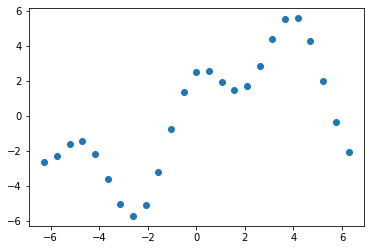

In [141]:
# dimension of data
d = 2
# number of samples
n = 25
# variance of noise
eps2 = 0
# determine if we should randomly rotate
rotate=False


# 2D manifold in 4D space

# sqrt_n = 25
# n = sqrt_n**2

# Z = np.zeros((d,n))
# for i in range(sqrt_n):
# 	for j in range(sqrt_n):
# 		x = (-0.5 + (i+1)/sqrt_n)*2*np.pi
# 		y = (-0.5 + (j+1)/sqrt_n)*2*np.pi
# 		Z[0,j + sqrt_n*i] = x
# 		Z[1,j + sqrt_n*i] = y
# 		Z[2,j + sqrt_n*i] = np.sin(4*x)
# 		Z[3,j + sqrt_n*i] = np.sin(7*y)


# # mean center
# Z = Z - np.mean(Z,axis=1,keepdims=True)
# # global normalization
# Z = Z * n / np.sqrt(np.sum(np.power(Z, 2)))

# plt.scatter(Z[0,:], Z[1,:])
scale=2
Z = np.zeros((d,n))
for i in range(n):
	x = (-0.5 + (i+1)/n)*2*np.pi
	Z[0,i] = x
	Z[1,i] = scale*np.sin(x) + scale/2*np.sin(3*x + 1.5)

# add noise
Z = Z + eps2*np.random.randn(d, n)


# center and scale
Z = Z - Z.mean(axis=1,keepdims=True)
Z = Z * n / np.linalg.norm(Z, 'fro')

# random rotation, preserves centering and scale
if rotate:
	A = np.random.randn(d,d)
	u,s,vt = np.linalg.svd(A)
	Z = u@Z

plt.scatter(Z[0,:], Z[1,:])

# PCA on manifold data

Showing the linear component PCA would choose to eliminate. Note it does not give the proper elimination

[-0.63103479  0.77575453]


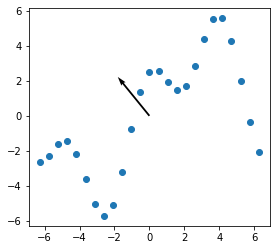

In [142]:
u, s, vt = np.linalg.svd(Z)
u_min = u[:,1]
print(u_min)

# scale to look nice on graph
u_show = u_min * np.min(np.max(np.abs(Z), axis=1))/2

plt.scatter(Z[0,:], Z[1,:])
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We would idealy get a vector in the span of $(0,1)$, since all extraneous curvature is in the $y$-direction. As can be seen, the direction of least variance does not necessarily correspond to the best direction to compress curvature.

# Curvature compression on manifold data

We now test our new proposed method, curvature compression. The function we theoretically want to optimize for is the following:

$$v_* = \argmin_{\|v\|_2 = 1} \max_{x, y \in Z \mid x \ne y} |\langle v, \frac{x-y}{\|x-y\|_2}\rangle|$$
$$= \argmin_{\|v\|_2 = 1} \|\langle v, \frac{x-y}{\|x-y\|_2}\rangle\|_\infty. $$

However, since the $L^\infty$ norm is hard to directly optimize, we settle for a smooth surrogate norm: the $L^4$-norm.

In [146]:
# PyTorch model to optimize our custom loss
class CurvatureElimination(nn.Module):

    def __init__(self, X, u_0):
        super(CurvatureElimination, self).__init__();
        # data
        self.X = X
        # construct edm and gamma weight matrix
        gram = X.T@X
        edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
                + torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
                - 2*gram

        # diagonal weights don't matter, set to 1 as convention
        self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
        # projection vec
        self.u = nn.Parameter(u_0)

    def forward(self):
        U_stacked = torch.ones(self.X.shape)*self.u
        A = (self.X.T @ U_stacked - U_stacked.T @ self.X)*self.gamma
        return 0.5*A.pow(4).sum()

In [155]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())
X = torch.Tensor(Z)

cc = CurvatureElimination(X, u_0)
opt = optim.SGD(cc.parameters(), lr=0.0001)

for i in range(10000):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		print(f'converged in {i} steps!')
		break
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

g step 0: 22.1259765625
g step 100: 15.4981050491333
g step 200: 11.87358283996582
g step 300: 8.929813385009766
g step 400: 6.253429889678955
g step 500: 4.05678653717041
g step 600: 2.480539083480835
g step 700: 1.4585487842559814
g step 800: 0.8374172449111938
g step 900: 0.4741568863391876
g step 1000: 0.26635727286338806
g step 1100: 0.14896006882190704
g step 1200: 0.08308668434619904
g step 1300: 0.046294793486595154
g step 1400: 0.02575899101793766
g step 1500: 0.014335391111671925
g step 1600: 0.007966628298163414
g step 1700: 0.00443057669326663
g step 1800: 0.0024690553545951843
g step 1900: 0.0013696736423298717
g step 2000: 0.0007629187311977148
g step 2100: 0.00041631245403550565
g step 2200: 0.00023809772392269224
g step 2300: 0.000115051785542164
g step 2400: 6.438935088226572e-05
converged in 2436 steps!
done!


learned compression direction: [[ 0.04941441 -0.99877834]]


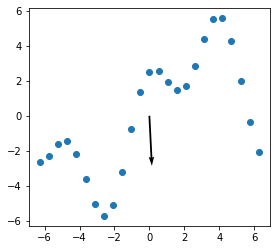

In [156]:
# show learned compression direction
u_ce = ce.u.data.detach().clone().numpy()

print(f'learned compression direction: {u_ce.T}')
# scale to look nice on graph
u_show = u_ce * np.min(np.max(np.abs(Z), axis=1))/2

plt.scatter(Z[0,:], Z[1,:])
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()